In [17]:
import numpy as np
import mdtraj as md
import matplotlib
import matplotlib.pyplot as plt
import itertools
import tqdm
%matplotlib inline


TypeError: 'module' object is not callable

# Hydrogen Bond Finder

This jupyter notebook will be used to search for hydrogen bonds in a simulation. Hydrogen bonds are defined as a dipole-dipole short-range interaction. They are often described as partially positive charged hydrogen bond donors (N-H, O-H, C-H) and partially negative charged hydrogen bond acceptors (O:, N:, C:). Hydrogen bonds are a weak intreaction, at 1-2 $kJ mol^{-1}$. However, they are strong enough to persist in molecular dynamics simulations.

In this notebook we will search for N-H hydrogen bond donors and O: hydrogen bond acceptors using coordinate geometry and atom names.

First we load in our simulation trajectory using `mdtraj`.

In [2]:
traj = md.load(["../octamer_controlled_box_fluctuations/PR/npt_whole.xtc"], top = "../octamer_controlled_box_fluctuations/PR/berendsen.gro") # "../Parsley/3/nvt_whole.xtc", "../Parsley/4/nvt_whole.xtc"] ,top="../Parsley/1/nvt_restrained.gro")
print(traj)

<mdtraj.Trajectory with 5295 frames, 7220 atoms, 1385 residues, and unitcells>


### Building H-acceptors/donors

In the next few cells we get lists of all atoms that make up the hydrogen bond acceptors and donors we're interested in analyzing.

In [3]:
top = traj.topology
os = top.select("element O")
traj.atom_slice(os)
len(os)

8

In [4]:
ns = top.select("element N and resname OCT")
traj.atom_slice(ns)
len(ns)

9

In [5]:
hs = top.select("element H and resname OCT")
traj.atom_slice(hs)
len(hs)

123

For the hydrogen bond donors of interest (N-H) we iterate over all hydrogens and nitrogens and append a donor pair to our list if the two atoms are within the bonded distance of a N-H bond (~0.105 nm). For the hydrogen bond acceptors we just use the list of oxygens in the system.

Be sure to check that you get the right number of acceptors and donors for your system. We only do this calculation on the begining frame of the simulation, because we don't expect hydrogen donors or acceptors to disapear or apear during the course of the simulation.

In [7]:
# get h_donors
h_donors = []
n_h = 0.105 ** 2
for pair in itertools.product(ns,hs):
    r1 = traj.xyz[0, pair[0], :] - traj.xyz[0, pair[1], :]
    if np.dot(r1,r1) < n_h:
        h_donors.append(pair)
# get h_acceptors
h_acceptors = os.tolist()
print(h_donors)
print(os)

[(64, 0), (64, 114), (68, 117), (101, 132), (154, 169), (191, 206), (228, 251), (250, 252), (274, 275), (297, 298), (297, 299)]
[ 61  99 152 189 226 248 272 295]


### Mapping H-accecptors/donors to residues

In this simulation, the molecule of interest did not have residues specified. For this reason I had to manually map the acceptors and donors indexes to specific resiude numbers. I also added the "MO" string for the methoxy hydrogen bond acceptors as these are an undesired interaction.

For systems with residue or chain numbers, this process might be automatable.

In [9]:
hd_to_res = {
            (64, 0) : 1, (64, 114) : 1,
            (68, 117) : 2,
            (101, 132) : 3,
            (154, 169) : 4,
            (191, 206) : 5,
            (228, 251) : 6,
            (250, 252) : 7,
            (274, 275) : 8, 
            (297, 298) : "END",
            (297, 299) : "END"
            }
ha_to_res = {
             61 : 1, 
             99 : 2, 
             152 : 3,
             189 : 4, 
             226 : 5, 
             248 : 6, 
             272 : 7,
             295 : 8,
            }

### Main Loop

In the main loop of this program we iterate over each possible pair of hydrogen bond acceptors and donors and calculate their distance and angle. If they fall within the definition of a hydrogen bond, we append that pair to a growing list of hydrogen bonds over each frame of the simulation.

In [10]:
h_bond = []
o_h = 0.3 ** 2
for i in tqdm.tqdm(range(traj.xyz.shape[0])):
    for pair in itertools.product(h_donors, h_acceptors):
        r2 = traj.xyz[i, pair[0][1],:] - traj.xyz[i, pair[1],:]
        d_sq = np.dot(r2,r2)
        if d_sq < o_h:
            r1 = traj.xyz[i, pair[0][0],:] - traj.xyz[i, pair[0][1],:]
            theta = np.arccos(np.dot(r1, r2) / np.sqrt(np.dot(r2,r2) * np.dot(r1,r1)))
            if np.abs(theta - np.pi) > (np.pi / 180 * 120):
                h_bond.append([pair[0], pair[1]])
            # print(traj.top.atom(pair[0]), traj.top.atom(pair[1]), traj.top.atom(pair[2]), d)

100%|██████████| 5295/5295 [00:01<00:00, 3235.22it/s]


Once we've built our list of all hydrogen bonds, we have to classify them into their respective interactions. This is achieved with the dictionaries we made 2 cells ago. Taking the difference between the residues of each hydrogen bond pair, we get the i to i + N interaction, we then append this to a growing hydrogen bond interaction list. Getting the unique and counts for this new interaction list gives us the frequency the heteropolymer was interacting with specific residues for the entire entire simulation.

In [11]:
h_bond_ints = []
# [hd_to_res[p[0]] - ha_to_res[p[1]] for p in h_bond]
for pair in h_bond:
    if hd_to_res[pair[0]] == "END":
        h_bond_ints.append("END")
    else:
        diff = hd_to_res[pair[0]] - ha_to_res[pair[1]]
        if diff >= 0:
            h_bond_ints.append("i to i + " + str(diff))
        else:
            h_bond_ints.append("i to i - " + str(np.abs(diff)))


In [12]:
unique, counts = np.unique(h_bond_ints, return_counts=True)

Text(0, 0.5, 'Counts')

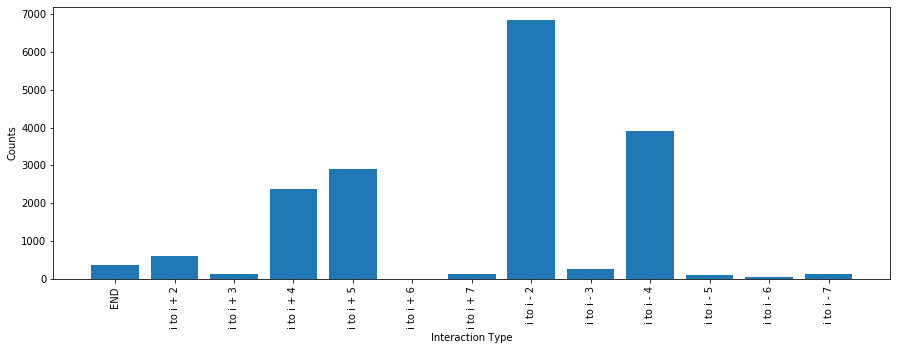

In [13]:
plt.figure(figsize=[15,5])
plt.bar(unique, counts)
plt.xticks(unique, rotation='vertical')
plt.xlabel("Interaction Type")
plt.ylabel("Counts")